Imports

In [1]:
import sys
sys.path.append("/home/sanketh/DANI/GraphMatching/")

import torch.multiprocessing as mp
mp.set_start_method("spawn")

In [2]:
import pathlib
import os
import numpy as np
import torch
from torch import optim
import itertools
from common.parallel_computation import tqdm_joblib
import random
from tqdm import tqdm
from joblib import Parallel, delayed
from os import cpu_count
import pickle
from livelossplot import PlotLosses
import time
from common.logger import TimeLogging
from subgraph_matching_via_nn.data.data_loaders import load_graph
from powerful_gnns.models.graphcnn import GraphCNN
from powerful_gnns.util import separate_data
from powerful_gnns.classifier_training import train, test
from common.EmbeddingCalculationsService import pairwise_l2_distance, show_distance_matrix, \
    calculate_energy_based_hidden_rep
from subgraph_matching_via_nn.training.PairSampleInfo import Pair_Sample_Info
from subgraph_matching_via_nn.data.annotated_graph import AnnotatedGraph
from subgraph_matching_via_nn.training.trainer.S2VGraphEmbeddingSimilarityMetricTrainer import \
    S2VGraphEmbeddingSimilarityMetricTrainer
from common.graph_data_experiments_utils import *

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!


In [3]:
processes_device_ids = [0, 2, 3, 4, 5, 6, 7]

In [4]:
goal_subcircuit_name = 'alu'
DATA_PATH = 'C:/Users/kogan/OneDrive/Desktop/Research/AMIT/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
DATA_PATH = '../subgraph_matching_via_nn/data/subcircuits/'

desktop = pathlib.Path(DATA_PATH)
subgraphs = []
labels = []
for circuit_dir in desktop.iterdir():
    if circuit_dir.is_dir():
        for subcircuit_file in circuit_dir.iterdir():
            if subcircuit_file.is_file():
                file_name = subcircuit_file.name
                if file_name == 'full_graph.p':
                    file_rel_path = f"{os.sep}{file_name}"
                    loader_params = {
                     'data_path' : str(circuit_dir),
                     'g_full_path': file_rel_path,
                     'g_sub_path': file_rel_path}

                    sub_graph = \
                        load_graph(type='subcircuit',
                                   loader_params=loader_params)

                    if goal_subcircuit_name in circuit_dir.name:
                        labels.append(1)
                    else:
                        # continue #TODO?
                        labels.append(0)
                    subgraphs.append(sub_graph)

labels = np.array(labels, dtype='float32')
N = len(subgraphs)
N_training = int(2 / 3 * N)

In [5]:
subgraphs = []
labels = []

subgraphs_for_classification = []

circuit_base_dir = 'C:\\Users\\kogan\\OneDrive\\Desktop\\Research\\AMIT\\GraphMatching\\subgraph_matching_via_nn\\data\\subcircuits\\'
circuit_base_dir = '/home/sanketh/DANI/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
CIRCUIT_DUPLICATES_AMOUNT = 5
REFERENCE_GRAPH_ORIGINAL_LABEL = 1
REFERENCE_GRAPH_ORIGINAL_INDEX = 0

for circuit_file_name in ['adder_4', 'alu_4', 'alu_8', 'alu_16', 'alu_32', 'mul_4_4', 'mul_4_8', 'mul_8_8', 'mul_16_16', 'mul_16_32']:
    file_rel_path = 'full_graph.p'
    circuit_dir = f"{circuit_base_dir}{circuit_file_name}{os.sep}"
    loader_params = {
     'data_path' : str(circuit_dir),
     'g_full_path': file_rel_path,
     'g_sub_path': file_rel_path}

    sub_graph = \
        load_graph(type='subcircuit',
                   loader_params=loader_params)
    subgraphs.append(sub_graph)
    for i in range(CIRCUIT_DUPLICATES_AMOUNT):
        subgraphs_for_classification.append(sub_graph)
        labels.append(0)
for i in range(CIRCUIT_DUPLICATES_AMOUNT):
    labels[REFERENCE_GRAPH_ORIGINAL_INDEX * CIRCUIT_DUPLICATES_AMOUNT + i] = REFERENCE_GRAPH_ORIGINAL_LABEL

zipped_graphs_and_labels = list(zip(subgraphs_for_classification, labels))
random.shuffle(zipped_graphs_and_labels)
unzipped_graphs_and_labels = list(zip(*zipped_graphs_and_labels))
subgraphs_for_classification = unzipped_graphs_and_labels[0]
labels = unzipped_graphs_and_labels[1]

N = len(subgraphs_for_classification)
N_training = int(2 / 3 * N)

Transform graphs into S2VGraph-s

In [6]:
device = 'cpu' if torch.cuda.is_available() else 'cpu'

In [7]:
graphs, num_classes = transform_into_s2vgraphs(subgraphs_for_classification, labels, device)

# classes: 2
# maximum node tag: 48
# data: 50


Setup model and training

In [8]:
#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

##k-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
# train_graphs, test_graphs = separate_data(graphs, seed=0, fold_idx=0, n_splits=1)
# train_graphs = graphs[:4]
# test_graphs = graphs[4:]
train_graphs = graphs[:N_training]
test_graphs = graphs[N_training:]

model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=train_graphs[0].node_features.shape[1], hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

Train and Test

In [ ]:
liveloss = PlotLosses(mode='notebook')

filename = ""
epochs = 20
k_update_plot = 1

for epoch in range(1, epochs + 1):
    scheduler.step()

    avg_loss = train(iters_per_epoch=50, batch_size=len(train_graphs), model=model, device=device, train_graphs=train_graphs, optimizer=optimizer, epoch=epoch)
    acc_train, acc_test = test(model, device, train_graphs, test_graphs, epoch)

    if not filename == "":
        with open(filename, 'w') as f:
            f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
            f.write("\n")
    print("")

    print(model.eps)

    if epoch % k_update_plot == 0:
        liveloss.update({'train error': avg_loss.item()})
        liveloss.send()

In [ ]:
acc_train

In [ ]:
acc_test

Show predictions

In [ ]:
model.eval()
pred = model(train_graphs).max(1, keepdim=True)[1]
print(pred)

In [ ]:
pred = model(test_graphs).max(1, keepdim=True)[1]
print(pred)

show all distances matrix (margin)

In [9]:
# keep only one instance of each graph
graphs, num_classes = transform_into_s2vgraphs(subgraphs, labels, device)

all_embeddings = model.get_embedding(graphs)

# classes: 2
# maximum node tag: 48
# data: 10


/home/sanketh/DANI/GraphMatching/powerful_gnns/models/graphcnn.py:150: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  graph_pool = torch.sparse.FloatTensor(idx, elem, torch.Size([len(batch_graph), start_idx[-1]]))


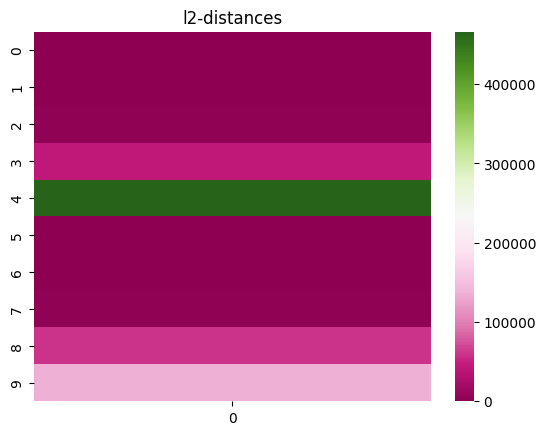

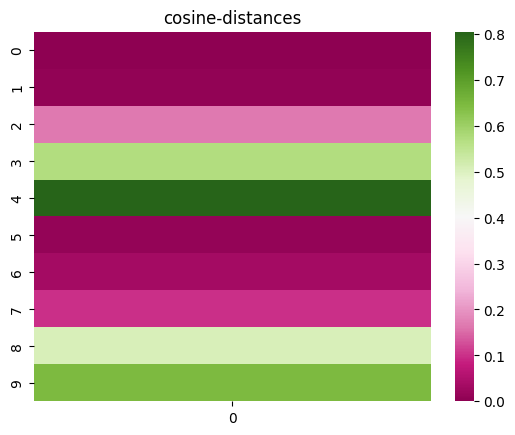

In [10]:
l2_dists = pairwise_l2_distance(all_embeddings)[REFERENCE_GRAPH_ORIGINAL_INDEX].reshape(-1, 1)

rounding_constant = 10 ** 3
cos_dists = (torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant)[REFERENCE_GRAPH_ORIGINAL_INDEX].reshape(-1, 1)

show_distance_matrix(l2_dists, "l2-distances")
show_distance_matrix(cos_dists, "cosine-distances")

what is the smallest margin?

In [11]:
print(get_min_non_diagonal_entry(l2_dists, device, REFERENCE_GRAPH_ORIGINAL_INDEX))
print(get_min_non_diagonal_entry(cos_dists, device, REFERENCE_GRAPH_ORIGINAL_INDEX))

43.02391052246094
0.007000000216066837


Contrastive loss training

Assemble graph pairs data

In [12]:
train_samples_list = []
reference_subgraph = subgraphs[REFERENCE_GRAPH_ORIGINAL_INDEX]
negative_examples_subgraphs = subgraphs[:REFERENCE_GRAPH_ORIGINAL_INDEX] + subgraphs[REFERENCE_GRAPH_ORIGINAL_INDEX+1:]

for subgraph in subgraphs:
    if subgraph == reference_subgraph:
        is_negative_example = False
    else:
        is_negative_example = True

    G1_annotated = AnnotatedGraph(subgraph.G)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

val_samples_list = train_samples_list

Define GNN model

In [13]:
# input dim matches the node mask (w) shape
input_dim = S2VGraphEmbeddingSimilarityMetricTrainer.get_model_expected_input_dim(train_samples_list[0])
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

Define graph metric to train, and the trainer

In [14]:
solver_params = {
    "device": device,
    "lr": 1e-3, "weight_decay": 1e-3,
    "max_epochs": 50,
    "cycle_patience": 5, "step_size_up": 10, "step_size_down": 10,
    "loss_convergence_threshold": None,
    "train_loss_convergence_threshold": 1e-3,
    "successive_convergence_min_iterations_amount": 5,
    "margin_loss_margin_value": 5,
    "max_grad_norm": 0.1,
    "k_update_plot": 1,
    "train_monitoring_epochs_pace": 5,
    "batch_size": len(subgraphs),
    "num_workers": 0,
    "is_use_model_compliation": False, #Only supported for Pytorch > 2.0
    "model_checkpoint_epochs_pace": 10,
}

problem_params = {"input_dim": input_dim}

trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params)

Train

In [ ]:
# show_distances_heatmap(generate_s2v_graphs([graph.g for graph in graphs], device), model, device)

In [ ]:
trainer.train(processes_device_ids=['cpu'], use_existing_data_loaders=False, train_samples_list=train_samples_list, val_samples_list=val_samples_list)

In [ ]:
show_distances_heatmap(generate_s2v_graphs([graph.g for graph in graphs], device), model, device)

Add ged=1 examples as positive examples

In [ ]:
# generate subgraphs for which ged(subgraph, reference_subgraph)==1
perturbed_graphs = list(generate_perturbed_graphs(reference_subgraph.G_sub))
for perturbed_graph in perturbed_graphs:
    is_negative_example = False

    G1_annotated = AnnotatedGraph(perturbed_graph)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

In [ ]:
len(train_samples_list)

In [ ]:
val_samples_list = train_samples_list
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = len(train_samples_list)

trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params)

trainer.train(processes_device_ids=['cpu'], use_existing_data_loaders=False, train_samples_list=train_samples_list, val_samples_list=val_samples_list)

In [ ]:
all_s2v_graphs = generate_s2v_graphs([subgraph.G for subgraph in subgraphs] + perturbed_graphs, device)
# show_distances_heatmap(all_s2v_graphs, model, device)

In [ ]:
show_distances_heatmap(all_s2v_graphs[:len(subgraphs)], model, device)

In [ ]:
reference_s2v_graph = all_s2v_graphs[REFERENCE_GRAPH_ORIGINAL_INDEX]
reference_graph_with_positive_examples = [reference_s2v_graph] + all_s2v_graphs[len(subgraphs):]
reference_graph_with_negative_examples = [all_s2v_graphs[i] for i in range(len(all_s2v_graphs[:len(subgraphs)]))]

In [ ]:
show_distances_heatmap(reference_graph_with_positive_examples, model, device, show_min_off_diagonal=False)

In [ ]:
show_distances_heatmap(reference_graph_with_negative_examples, model, device, show_min_off_diagonal=True)

In [ ]:
_ = graph_metric_nn.eval()

In [ ]:
positive_distances = []
for positive_example_second_graph in reference_graph_with_positive_examples:
    distance = graph_metric_nn.forward([(reference_s2v_graph, positive_example_second_graph)]).item()
    positive_distances.append(distance)
    if distance > solver_params['margin_loss_margin_value']:
        print(f"positive loss term not zero, as distance for this positive example pair is {distance}")

negative_distances = []
for negative_example_second_graph in reference_graph_with_negative_examples:
    if negative_example_second_graph == reference_s2v_graph:
        continue #ignore the same graph with itself
    distance = graph_metric_nn.forward([(reference_s2v_graph, negative_example_second_graph)]).item()
    negative_distances.append(distance)
    if distance < solver_params['margin_loss_margin_value']:
        print(f"negative loss term not zero, as distance for this negative example pair is {distance}")

In [ ]:
max(positive_distances)

In [ ]:
min(negative_distances)

k-subgraphs experiment

In [ ]:
K = 11
full_graph = reference_subgraph.G

subgraphs_iterator = itertools.combinations(full_graph, K)
k_subgraphs = [full_graph.subgraph(s) for s in subgraphs_iterator]
k_subgraph_annotated_graphs = [AnnotatedGraph(g, label=i) for i, g in enumerate(k_subgraphs)]

train_samples_list = []
isomorphic_pairs = []
train_sample_indices_tuple_list = []

In [ ]:
for subgraph_counter1, SG_annotated_1 in enumerate(k_subgraph_annotated_graphs):
    for subgraph_counter2 in range(subgraph_counter1+1, len(k_subgraph_annotated_graphs)):
        SG_annotated_2 = k_subgraph_annotated_graphs[subgraph_counter2]
        train_samples_list.append(compare_graphs_and_generate_pair_example(SG_annotated_1, SG_annotated_2, isomorphic_pairs))
        train_sample_indices_tuple_list.append((subgraph_counter1, subgraph_counter2))
        # if train_samples_list[-1].is_negative_sample == False:
        #     print(f"{subgraph_counter1} vs {subgraph_counter2}")

In [ ]:
used_train_samples_list = train_samples_list[:10_000]

In [ ]:
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=128, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 50
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=None)

trainer.train(processes_device_ids=[0], use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])

In [ ]:
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path="./mp/1704585490.4369323/best_model_state_dict.pt")
_ = graph_metric_nn.eval()

In [ ]:
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, used_train_samples_list)
plot_histogram(train_positive_distances, "positive pair distances", min_range=0, max_range=20)
plot_histogram(train_negative_distances, "negative pair distances", min_range=0, max_range=20)
calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [ ]:
# ged_pairs_dump_base_path = f".{os.sep}ged_pairs

# loaded_ged_examples = []
# for i, doc_path in enumerate(pathlib.Path(ged_pairs_dump_base_path).rglob("*.p*")):
#     k_subgraph_ged_pairs_list = pickle.load(open(doc_path, 'rb'))
#     loaded_ged_examples += k_subgraph_ged_pairs_list
#     print(i)

# if not os.path.exists(ged_pairs_dump_base_path):
#     os.makedirs(ged_pairs_dump_base_path)
#
# # k_subgraph_to_perturbed_graphs_map = {}
# def generate_ged_paris(subgraph_counter1):
#     train_samples_list = []
#     SG1 = k_subgraph_annotated_graphs[subgraph_counter1]
#     ged1_perturbed_graphs = list(generate_perturbed_graphs(SG1.g))
#     for ged1_perturbed_graph in ged1_perturbed_graphs:
#         # positive example
#         train_samples_list.append(generate_pair_example(SG1, AnnotatedGraph(ged1_perturbed_graph), is_negative_example = False))
#
#         ged2_perturbed_graphs = list(generate_perturbed_graphs(ged1_perturbed_graph))
#         for ged2_perturbed_graph in ged2_perturbed_graphs:
#             # could be positive or negative example
#             train_samples_list.append(compare_graphs_and_generate_pair_example(k_subgraph_annotated_graphs[subgraph_counter1], AnnotatedGraph(ged2_perturbed_graph)))
#
#     path = os.path.join(ged_pairs_dump_base_path, f"subgraph_{subgraph_counter1}.p")
#     with open(path, 'wb') as f:
#         pickle.dump(train_samples_list, f)
#     return train_samples_list
#
# total_tasks = len(k_subgraphs)
# with tqdm_joblib(tqdm(desc="My calculation", total=total_tasks)) as progress_bar:
#     #Parallel(n_jobs=16)(delayed(long_task)() for i in range(10))
#
#     ged_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
#         delayed(generate_ged_paris)(subgraph_counter1=subgraph_counter1)
#         for subgraph_counter1 in range(total_tasks)
#     )
#
# # generate subgraphs for which GED==1
# for subgraph_counter1, SG1 in enumerate(k_subgraphs):
#     print(subgraph_counter1)
#     ged1_perturbed_graphs = list(generate_perturbed_graphs(SG1))
#     for ged1_perturbed_graph in ged1_perturbed_graphs:
#         # positive example
#         train_samples_list.append(generate_pair_example(SG1, ged1_perturbed_graph, is_negative_example = False))
#         #
#         # ged2_perturbed_graphs = list(generate_perturbed_graphs(ged1_perturbed_graph))
#         # for ged2_perturbed_graph in ged2_perturbed_graphs:
#         #     # could be positive or negative example
#         #     train_samples_list.append(compare_graphs_and_generate_pair_example(k_subgraph_annotated_graphs[subgraph_counter1], AnnotatedGraph(ged2_perturbed_graph)))
#     # k_subgraph_to_perturbed_graphs_map[SG1] = perturbed_graphs

#
#
# # generate all pairs examples
# for SG1, SG1_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#     for SG2, SG2_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#
#         if SG1 == SG2:
#             continue # trivial pairs, or pairs already considered
#
#         for SG2_perturbed_graph in SG2_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1, SG2_perturbed_graph))
#
#         for SG1_perturbed_graph in SG1_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1_perturbed_graph, SG2))

In [ ]:
random_k_subgraphs = generate_k_subgraph(reference_subgraph, k=9)

In [ ]:
len(random_k_subgraphs)

In [ ]:
POSITIVE_EXAMPLES_GED_DIST_pairs_n = 20 #2000
POSITIVE_EXAMPLES_GED_DIST = 1
POSITIVE_EXAMPLES_k_subgraphs = random_k_subgraphs

NEGATIVE_EXAMPLES_GED_DIST_pairs_n = 20
NEGATIVE_EXAMPLES_GED_DIST = 4 #4
NEGATIVE_EXAMPLES_k_subgraphs = random_k_subgraphs#[:20]

ged_examples1, ged_examples2 = generate_positive_and_negative_ged_pairs(POSITIVE_EXAMPLES_k_subgraphs, POSITIVE_EXAMPLES_GED_DIST, POSITIVE_EXAMPLES_GED_DIST_pairs_n, NEGATIVE_EXAMPLES_k_subgraphs, NEGATIVE_EXAMPLES_GED_DIST, NEGATIVE_EXAMPLES_GED_DIST_pairs_n)

ged_examples = ged_examples1 + ged_examples2
random.shuffle(ged_examples)

train_ratio = 0.7
train_ged_examples_amount = int(len(ged_examples) * train_ratio)
train_ged_examples = ged_examples[:train_ged_examples_amount]
eval_ged_examples = ged_examples[train_ged_examples_amount:]

In [ ]:
len(train_ged_examples)

In [ ]:
len(ged_examples2)

In [ ]:
len(ged_examples1)

In [ ]:
for k_subgraph in k_subgraphs:
    if k_subgraphs[0].nodes == k_subgraph.nodes:
        print("yes")

In [ ]:
len(k_subgraphs)

In [ ]:
len(train_ged_examples)

check 1-WL distance

In [ ]:
# optimized single call for WL distance calculation
### NOTE: Wl dist is not stable (depends which batch of graph you applied it with) ###
# wl_dist_matrix = get_graph_wl_distances(k_subgraphs, node_label=False)

# negative_pairs_wl_distances = []
# positive_pairs_wl_distances = []
#
# positive_pairs_index_to_dist_map = {}
# negative_pairs_index_to_dist_map = {}
#
# for i, train_sample in enumerate(train_samples_list):
#     is_negative_sample = train_sample.is_negative_sample
#     graph1 = train_sample.subgraph
#     graph2 = train_sample.masked_graph
#
#     # s2v_graphs = generate_s2v_graphs([graph1.g, graph2.g], device, print_stats=False)
#
#     # distance = graph_metric_nn.forward([(s2v_graphs[0], s2v_graphs[1])]).item()
#
#     # wl_dist = get_graph_wl_distances([graph1.g, graph2.g], node_label=False)[0][1]
#
#     graph1_index, graph2_index = train_sample_indices_tuple_list[i]
#     wl_dist = wl_dist_matrix[graph1_index][graph2_index]
#     wl_dist = round(wl_dist, 6)
#
#     if is_negative_sample:
#         negative_pairs_wl_distances.append(wl_dist)
#         negative_pairs_index_to_dist_map[i] = wl_dist
#     else:
#         positive_pairs_wl_distances.append(wl_dist)
#         positive_pairs_index_to_dist_map[i] = wl_dist

In [ ]:
# _, _ = show_wl_dist_histograms(ged_1_examples, ged_2_examples, max_examples_amount = 1_000)

In [ ]:
# margin = 0.001
# calc_margin_loss(torch.tensor(positive_pairs_wl_distances+negative_pairs_wl_distances), torch.cat((torch.ones(len(positive_pairs_wl_distances)), torch.zeros(len(negative_pairs_wl_distances)))), margin)

Fit GNN on k subgraph GED pairs

In [ ]:
# disable debugging overhead operations
torch.autograd.set_detect_anomaly(mode=False)

In [ ]:
solver_params['margin_loss_margin_value'] = 0.5 #0.25 #0.01

In [ ]:
# used_train_samples_amount = 50_000
used_train_samples_list = train_ged_examples#[:used_train_samples_amount] #Needed due to performance issues

In [ ]:
len(used_train_samples_list)

In [ ]:
last_checkpoint_model_path = None

# val_samples_list = used_train_samples_list
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=128, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512 * 8 #32 #2048 #1024 #512
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 200 #480--
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=last_checkpoint_model_path)

# trainer.set_existing_data_loader_paths(
#     ['./dataloaders/1702148493.0283618.p',
#  './dataloaders/1702148497.9922142.p',
#  './dataloaders/1702148502.9499629.p',
#  './dataloaders/1702148511.1819935.p'],
# []
# )

In [ ]:
trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])

In [ ]:
# GED2 -> "./mp/1703271648.8009052/best_model_state_dict.pt", not seperable well
# GED4 - > ""./mp/1703279923.1549501/best_model_state_dict.pt", seperable well (not perfect but close)

In [ ]:
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path="./mp/1703411975.73806/best_model_state_dict.pt")
_ = graph_metric_nn.eval()

In [ ]:
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, used_train_samples_list)

In [ ]:
len(train_negative_distances) / len(train_positive_distances)

In [ ]:
plot_histogram(train_positive_distances, "train positive examples", min_range=0, max_range=1)

In [ ]:
plot_histogram(train_negative_distances, "train negative examples", min_range=0, max_range=10)

In [ ]:
calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

Train again without rebuilding data loaders, and without the val_loader

In [ ]:
# model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
# new_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params)

# new_trainer.previous_train_loader_paths = trainer.previous_train_loader_paths
# new_trainer.previous_val_loader_paths = [None for device_id in processes_device_ids] #trainer.previous_val_loader_paths
# new_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=True)

In [ ]:
_, _ = calc_performance_metrics(graph_metric_nn, used_train_samples_list, train_positive_distances, train_negative_distances, solver_params, device)

Generalization error

In [ ]:
eval_positive_distances, eval_negative_distances = get_examples_distances(trainer, graph_metric_nn, eval_ged_examples)

In [ ]:
plot_histogram(eval_positive_distances, "eval positive examples", max_range=10)

In [ ]:
plot_histogram(eval_negative_distances, "eval negative examples", max_range=10)

In [ ]:
calc_margin_loss(torch.tensor(eval_positive_distances+eval_negative_distances), torch.cat((torch.ones(len(eval_positive_distances)), torch.zeros(len(eval_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [ ]:
_, _ = calc_performance_metrics(graph_metric_nn, eval_ged_examples, eval_positive_distances, eval_negative_distances, solver_params, device)

Execution time profiling

In [ ]:
# from cProfile import Profile
# from pstats import SortKey, Stats

# with Profile() as profile:
#     new_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=True)
#     (
#     Stats(profile)
#         .strip_dirs()
#         .sort_stats(SortKey.CUMULATIVE)
#         .print_stats()
#     )

## save used_train_samples_list

In [ ]:
ref_graphs_with_negative_eaxmples = set([annotated_graph.label for annotated_graph in NEGATIVE_EXAMPLES_k_subgraphs])
ref_graphs_with_positive_eaxmples = set([annotated_graph.label for annotated_graph in POSITIVE_EXAMPLES_k_subgraphs])
reg_graphs_with_negative_and_positive_examples = ref_graphs_with_negative_eaxmples.intersection(ref_graphs_with_positive_eaxmples)

reference_graph_to_pairs_for_training_list_map = {}

for pair in used_train_samples_list:
    ref_graph = pair.subgraph
    ref_graph_label = pair.subgraph.label

    if ref_graph_label not in reg_graphs_with_negative_and_positive_examples:
        continue
    
    paired_graph = pair.masked_graph

    lst = []
    if ref_graph_label in reference_graph_to_pairs_for_training_list_map:
        lst = reference_graph_to_pairs_for_training_list_map[ref_graph_label]
    lst.append(pair)
    reference_graph_to_pairs_for_training_list_map[ref_graph_label] = lst

In [ ]:
dump_base_path = f".{os.sep}ged_train_subset"
if not os.path.exists(dump_base_path):
    os.makedirs(dump_base_path)

dump_path = os.path.join(dump_base_path, f"{str(time.time())}.p")
with open(dump_path, 'wb') as f:
    pickle.dump(reference_graph_to_pairs_for_training_list_map, f)

In [ ]:
p_ctr = 0
n_ctr = 0
for k, v in reference_graph_to_pairs_for_training_list_map.items():
    for example in v:
        if example.is_negative_sample:
            n_ctr += 1
        else:
            p_ctr += 1

In [ ]:
p_ctr

In [ ]:
n_ctr

Capacity test

In [ ]:
hidden_dim = 16
num_layers = 5
num_mlp_layers = 2
model_factory_func = lambda device: GraphCNN(num_layers=num_layers, num_mlp_layers = num_mlp_layers, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512 * 8
solver_params["k_update_plot"] = 10
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 200
current_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path="./mp/1705969912.0095499/best_model_state_dict.pt")

In [ ]:
trainer = None
hid_dim_to_val_loss_map = {}
for hid_dim in [16, 32, 64, 128, 256, 512, 1024, 2048]:
    trainer, graph_metric_nn, best_val_loss = train_model_with_hyperparams(used_train_samples_list, solver_params, problem_params, processes_device_ids, hidden_dim=hid_dim, trainer=trainer)
    hid_dim_to_val_loss_map[hid_dim] = best_val_loss
    print(f"{hid_dim}: {best_val_loss}")

In [ ]:
print(hid_dim_to_val_loss_map)
plot_map(hid_dim_to_val_loss_map, "hidden_dim", "val loss", "model performance vs model capacity")

Expressivity test

In [ ]:
positive_GED_k_to_negative_GED_k_to_val_loss_map = {}
pairs_n = 800
positive_examples_k_subgraphs = random_k_subgraphs[:20]
ged_positive_examples_cache_map = {}
ged_negative_examples_cache_map = {}

for positive_GED_k in [2, 3, 4, 5, 6, 7]:
    negative_GED_k_to_val_loss_map = {}
    positive_GED_k_to_negative_GED_k_to_val_loss_map[positive_GED_k] = negative_GED_k_to_val_loss_map

    # prepare positive pairs dataset
    with tqdm_joblib(tqdm(desc="My calculation", total=len(positive_examples_k_subgraphs))) as progress_bar:
        ged_positive_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
            delayed(generate_random_ged_paris)(annotated_subgraph=annotated_subgraph, ged_dist=positive_GED_k, pairs_n=pairs_n, is_negative_example=False, force_exactly_pairs_n=False)
            for annotated_subgraph in positive_examples_k_subgraphs
        )
    ged_positive_examples = [elem for lst in ged_positive_examples for elem in lst]
    ged_positive_examples_cache_map[positive_GED_k] = ged_positive_examples
    print(f"#pos examples = {len(ged_positive_examples)}")

    for negative_GED_k in range(positive_GED_k + 1, 9):
        print(f"expressivity test for positive_GED_k={positive_GED_k} & negative_GED_k={negative_GED_k}")

        if negative_GED_k in ged_negative_examples_cache_map:
            ged_negative_examples = ged_negative_examples_cache_map[negative_GED_k]
        else:

            # prepare negative pairs dataset
            with tqdm_joblib(tqdm(desc="My calculation", total=len(NEGATIVE_EXAMPLES_k_subgraphs))) as progress_bar:
                ged_negative_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
                    delayed(generate_random_ged_paris)(annotated_subgraph=annotated_subgraph, ged_dist=negative_GED_k, pairs_n=pairs_n, is_negative_example=True, force_exactly_pairs_n=False)
                    for annotated_subgraph in NEGATIVE_EXAMPLES_k_subgraphs
                )

            ged_negative_examples = [elem for lst in ged_negative_examples for elem in lst]
            ged_negative_examples_cache_map[negative_GED_k] = ged_negative_examples
        print(f"#neg examples = {len(ged_negative_examples)}")

        # combine examples to one dataset
        ged_examples = ged_positive_examples + ged_negative_examples
        random.shuffle(ged_examples)

        train_ratio = 0.7
        train_ged_examples_amount = int(len(ged_examples) * train_ratio)
        train_ged_examples = ged_examples[:train_ged_examples_amount]
        eval_ged_examples = ged_examples[train_ged_examples_amount:]

        print(f"#train set examples = {len(train_ged_examples)}")

        # train
        trainer, graph_metric_nn, best_val_loss = train_model_with_hyperparams(train_ged_examples, solver_params, problem_params, processes_device_ids, hidden_dim=64, trainer=None)
        negative_GED_k_to_val_loss_map[negative_GED_k] = best_val_loss
        print(f"negative K={negative_GED_k}: val_loss={best_val_loss}")

        # more performance metrics
        _ = graph_metric_nn.eval()

        train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, train_ged_examples)
        _, _ = calc_performance_metrics(graph_metric_nn, train_ged_examples, train_positive_distances, train_negative_distances, solver_params, device)

        eval_positive_distances, eval_negative_distances = get_examples_distances(trainer, graph_metric_nn, eval_ged_examples)
        _, _ = calc_performance_metrics(graph_metric_nn, eval_ged_examples, eval_positive_distances, eval_negative_distances, solver_params, device)
        calc_margin_loss(torch.tensor(eval_positive_distances+eval_negative_distances), torch.cat((torch.ones(len(eval_positive_distances)), torch.zeros(len(eval_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

        plot_histogram(train_positive_distances, "train positive examples", min_range=0, max_range=2)
        plot_histogram(train_negative_distances, "train negative examples", min_range=0, max_range=2)
        plot_histogram(eval_positive_distances, "eval positive examples", min_range=0, max_range=2)
        plot_histogram(eval_negative_distances, "eval negative examples", min_range=0, max_range=2)

In [ ]:
GED_experiments_map = {}
for positive_GED_k, negative_GED_k_to_val_loss_map in positive_GED_k_to_negative_GED_k_to_val_loss_map.items():
    for negative_GED_k, val_loss in negative_GED_k_to_val_loss_map.items():
        GED_experiments_map[f"{positive_GED_k}_{negative_GED_k}"] = val_loss

chart_bar_plot(GED_experiments_map, "positive-GED-K_negative-GED-K", "validation loss", "model expressivity analysis")

test of 2D features space to illustrate the GED - apply MDS to separate the pairs (show the separation of the two areas) show we get a smooth wrap function using a higher dimensional embedding

In [ ]:
# choose reference graph s.
reference_graph_for_GED_visualization = random_k_subgraphs[0]

# generate 50 s+GED-1 graphs for positive examples (remember label)
# generate 50 s+GED-4 graphs for negative examples (remember label)
negative_ged_pairs, positive_ged_pairs = create_ged_visulaization_graphs(reference_graph_for_GED_visualization, label_class_examples_amount=500, positive_GED=3, negative_GED=6)

In [ ]:
# load trained pairs, and visualize some reference graphs and their pairs
trained_pairs_path = f".{os.sep}ged_train_subset{os.sep}1705968201.9176743.p"
trained_pairs_map = pickle.load(open(trained_pairs_path, 'rb'))

In [ ]:
ctr = 0
for ref_graph_label, ref_graph_pairs in trained_pairs_map.items():
    if len(ref_graph_pairs) > 35:
        neg_pairs_ctr = 0
        for pair in ref_graph_pairs:
            if pair.is_negative_sample:
                neg_pairs_ctr += 1
        print(f"reference graph label: {ref_graph_label}, negative pairs amount = {neg_pairs_ctr}")
        ctr += 1

print(ctr)

In [ ]:
def visualize_embeddings_for_trained_model(ref_graph, positive_pairs, negative_pairs, solver_params, problem_params, input_dim, num_classes):
    for hidden_dim in [16, 32, 64, 128, 256, 512, 1024, 2048]:
        print(hidden_dim)
        model_dump_path = get_model_dump_path(hidden_dim)

        model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

        _, graph_metric_nn, _ = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=model_dump_path)

        # calc embeddings of all pairs, apply MDS and plot
        visualize_embeddings(graph_metric_nn, ref_graph, positive_pairs, negative_pairs, device=device)

In [ ]:
selected_train_reference_graph_pairs = trained_pairs_map[1799]
selected_train_reference_graph = selected_train_reference_graph_pairs[0].subgraph
selected_train_reference_graph_positive_pairs = [pair for pair in selected_train_reference_graph_pairs if pair.is_negative_sample == False]
selected_train_reference_graph_negative_pairs = [pair for pair in selected_train_reference_graph_pairs if pair.is_negative_sample == True]

visualize_embeddings_for_trained_model(selected_train_reference_graph, selected_train_reference_graph_positive_pairs, selected_train_reference_graph_negative_pairs, solver_params, problem_params, input_dim=1, num_classes=1, device=device)

In [ ]:
visualize_embeddings_for_trained_model(reference_graph_for_GED_visualization, positive_ged_pairs, negative_ged_pairs, solver_params, problem_params, input_dim=1, num_classes=1, device=device)

In [ ]:
gt_labels = [0] + [0 for pair in positive_ged_pairs] + [1 for pair in negative_ged_pairs]
hid_dim_to_clustering_score_maps_map = {}

for hidden_dim in [16, 32, 64, 128, 256, 512, 1024, 2048]:
    model_dump_path = get_model_dump_path(hidden_dim)
    model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=1, hidden_dim=hidden_dim, output_dim=1, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

    _, graph_metric_nn, _ = init_embedding_net_and_trainer(model_factory_func, model_dump_path)

    # calc embeddings of all pairs
    all_embeddings = get_embeddings(graph_metric_nn, reference_graph_for_GED_visualization, positive_ged_pairs, negative_ged_pairs)\
    .detach().cpu().numpy()

    # cluster and measure clustering quality
    hid_dim_to_clustering_score_maps_map[hidden_dim] = measure_clustering(all_embeddings, gt_labels)

In [ ]:
hid_dim_to_clustering_score_maps_map

In [ ]:
show_score_plot(hid_dim_to_clustering_score_maps_map, 'sil', 'silhouette')

In [ ]:
show_score_plot(hid_dim_to_clustering_score_maps_map, 'dav', 'davies-bouldin')

In [ ]:
show_score_plot(hid_dim_to_clustering_score_maps_map, 'nmi', 'nmi')

In [ ]:
# metric vs GED 3D plot
# 	for the X and Y, use radius-s of GED, e.g. for radius =1, all GED-1 examples (against a fixed reference graph)

# interactive mode may cause issues, see: https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab

%matplotlib notebook

In [ ]:
#TODO:
# 	what about the sampled graphs in the space, are they random? or they are sampled real subgraphs from the full graph?
# 		allow both configurations:
# 			all GED
# 			just existing sampled subgraphs GED (we can color them among all GED actually)

In [ ]:
visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, random_k_subgraphs[10], GED_dists = [1, 4], max_samples_per_radius = 50)

In [ ]:
multiple_ged_radiuses_graphs_map = visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, random_k_subgraphs[15], GED_dists = [1, 4, 9], max_samples_per_radius = 500)

In [ ]:
multiple_ged_radiuses_graphs_map = visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, random_k_subgraphs[15], GED_dists = [1, 4, 9], max_samples_per_radius = 500)

In [ ]:
visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, reference_graph_for_GED_visualization, GED_dists = [3, 6], max_samples_per_radius = 50)

In [ ]:
train_ged_dist_to_pairs_map = {1: selected_train_reference_graph_positive_pairs, 4: selected_train_reference_graph_negative_pairs}
visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, selected_train_reference_graph, GED_dists = train_ged_dist_to_pairs_map, max_samples_per_radius = 50)

In [ ]:
train_positive_distances, train_negative_distances = calc_margin_loss_for_pairs(trainer, graph_metric_nn, solver_params, selected_train_reference_graph_positive_pairs + selected_train_reference_graph_negative_pairs)

In [ ]:
max(train_positive_distances)

In [ ]:
min(train_negative_distances)

In [ ]:
trainer, graph_metric_nn = create_metric_and_trainer(hidden_dim=1024, solver_params=solver_params, problem_params=problem_params)
_ = graph_metric_nn.eval()
epoch_val_loss = 0
val_samples_list = positive_ged_pairs + negative_ged_pairs
stub_train_samples_list = val_samples_list[:1]
train_loaders, val_loaders = trainer.get_data_loaders(stub_train_samples_list, val_samples_list, 0, ['cpu'])
val_loader = val_loaders[0]

for val_batch in val_loader:
    val_loss = trainer.calculate_loss_for_batch(val_batch, is_train=False)
    epoch_val_loss += val_loss.item()

In [ ]:
epoch_val_loss

In [ ]:
# all_train_reference_graph_pairs = [pair for _, train_reference_graph_pairs in trained_pairs_map.items() for pair in train_reference_graph_pairs]
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, ged_examples1 + ged_examples2)

calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [ ]:
plot_histogram(train_positive_distances, "positive pair distances", min_range=0, max_range=1)
plot_histogram(train_negative_distances, "negative pair distances", min_range=0, max_range=7)

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 1, multiple_ged_radiuses_graphs_map[1])

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 4, multiple_ged_radiuses_graphs_map[4], max_range=0.2)

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 4, multiple_ged_radiuses_graphs_map[4], max_range=1)

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 4, multiple_ged_radiuses_graphs_map[4])

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 9, multiple_ged_radiuses_graphs_map[9])

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 9, multiple_ged_radiuses_graphs_map[9], max_range=3)

In [ ]:
# plt.close('all')

# Brute force training

In [15]:
brute_force_k_subgraph_annotated_graphs = generate_pairs_data_set(circuit_base_dir=circuit_base_dir, circuit_file_name = 'comp1_2')

enter generate_pairs_data_set
graph has 16 nodes
starting generating subgraphs
start generate_k_subgraphs
enter generate_k_subgraphs
total time for finished all_connected_subgraphs (total of 6205 graphs):0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #52 finished, chunk size=71:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #34 finished, chunk size=71:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #67 finished, chunk size=71:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #83 finished, chunk size=71:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #23 finished, chunk size=71:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #35 finished, chunk size=71:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #38 finished, chunk size=71:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #2 finished, chunk size=71:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #32 finished, chunk size


KeyboardInterrupt



In [ ]:
len(brute_force_k_subgraph_annotated_graphs)

In [23]:
brute_force_train_samples_list = []
for chunk_index in range(0, 88):
    with open(f'brute_force_pairs{os.sep}{chunk_index}.p', 'rb') as file:
        tmp_brute_force_train_samples_list = pickle.load(file)
    print(len(tmp_brute_force_train_samples_list))
    brute_force_train_samples_list += tmp_brute_force_train_samples_list

437999
432958
427917
422876
417835
412794
407753
402712
397671
392630
387589
382548
377507
372466
367425
362384
357343
352302
347261
342220
337179
332138
327097
322056
317015
311974
306933
301892
296851
291810
286769
281728
276687
271646
266605
261564
256523
251482
246441
241400
236359
231318
226277
221236
216195
211154
206113
201072
196031
190990
185949
180908
175867
170826
165785
160744
155703
150662
145621
140580
135539
130498
125457
120416
115375
110334
105293
100252
95211
90170
85129
80088
75047
70006
64965
59924
54883
49842
44801
39760
34719
29678
24637
19596
14555
9514
4473
378


In [ ]:
#TODO - make sure no ismorphic graphs, if there are make some manipulation

In [24]:
used_train_samples_list = brute_force_train_samples_list

In [25]:
len(used_train_samples_list)

19247910

In [26]:
hidden_dim = 16
num_layers = 5
num_mlp_layers = 2
model_factory_func = lambda device: GraphCNN(num_layers=num_layers, num_mlp_layers = num_mlp_layers, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512 * 8
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 200
current_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=None)

In [ ]:
current_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])